<a href="https://colab.research.google.com/github/gibril1435/GWR/blob/main/GWR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Adding necessary libraries to Google Colab environment

# Installing the 'contextily' library for adding basemaps to plots
!pip install contextily -q

# Installing the 'splot' library for spatial data visualization
!pip install splot -q

# Installing additional libraries for spatial analysis and visualization
#!pip install rasterio -q  # Library for reading and writing raster data
#!pip install linearmodels==4.27 -q  # Library for linear models and instrumental variables
!pip install mapclassify -q  # Library for choropleth mapping
#!pip install inequality -q  # Library for measuring economic inequality

# Installing the 'mgwr' library for performing geographically weighted regression
!pip install mgwr -q

!pip install stargazer -q

In [ ]:
# Load libraries
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from pylab import rcParams
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 72

import seaborn as sns
sns.set_style("darkgrid")
sns.set_context(context="paper", font_scale=1.5, rc=None)
sns.set(font="serif")

import plotly.express as px
import plotly.graph_objects as go

import geopandas as gpd


import libpysal as ps
from libpysal  import weights
from libpysal.weights import Queen

import esda
from esda.moran import Moran, Moran_Local

import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster, plot_local_autocorrelation
from splot.libpysal import plot_spatial_weights

from giddy.directional import Rose

import statsmodels.api as sm
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer, LineLocation

from spreg import OLS
from spreg import MoranRes
from spreg import ML_Lag
from spreg import ML_Error

from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import shift_colormap, truncate_colormap

import warnings
warnings.filterwarnings('ignore')
import time

In [ ]:
# Load Jawa Tengah dataset
gdf  = gpd.read_file('/content/drive/MyDrive/GWR/spasial_jateng.zip')
#gdf  = gpd.read_file(ps.examples.get_path('G_utm.shp'))

In [ ]:
gdf.columns

Index(['ADM0_EN', 'date', 'validOn', 'PROVINCE', 'Kabupaten', 'PRV2',
       'geometry'],
      dtype='object')

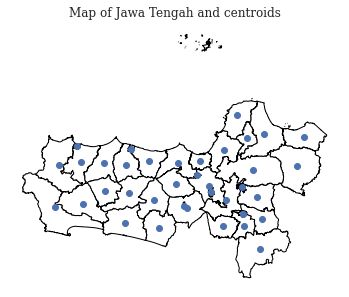

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
gdf.plot(color = 'white', edgecolor = 'black', ax = ax)
gdf.centroid.plot(ax=ax)
ax.set_title('Map of Jawa Tengah and centroids', fontsize=12)
ax.axis("off")
#plt.savefig('myMap.png',dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
gdf.crs
gdf.head()

,ADM0_EN,date,validOn,PROVINCE,Kabupaten,PRV2,geometry
0,Indonesia,2019-12-20,2020-04-01,Jawa Tengah,Banjarnegara,Jawa_Tengah,"POLYGON ((109.80041 -7.17174, 109.80093 -7.172..."
1,Indonesia,2019-12-20,2020-04-01,Jawa Tengah,Banyumas,Jawa_Tengah,"POLYGON ((109.22521 -7.24726, 109.22526 -7.247..."
2,Indonesia,2019-12-20,2020-04-01,Jawa Tengah,Batang,Jawa_Tengah,"POLYGON ((109.72577 -6.87245, 109.72718 -6.872..."
3,Indonesia,2019-12-20,2020-04-01,Jawa Tengah,Blora,Jawa_Tengah,"POLYGON ((111.2271 -6.84836, 111.2272 -6.84837..."
4,Indonesia,2019-12-20,2020-04-01,Jawa Tengah,Boyolali,Jawa_Tengah,"POLYGON ((110.74606 -7.14104, 110.74616 -7.141..."


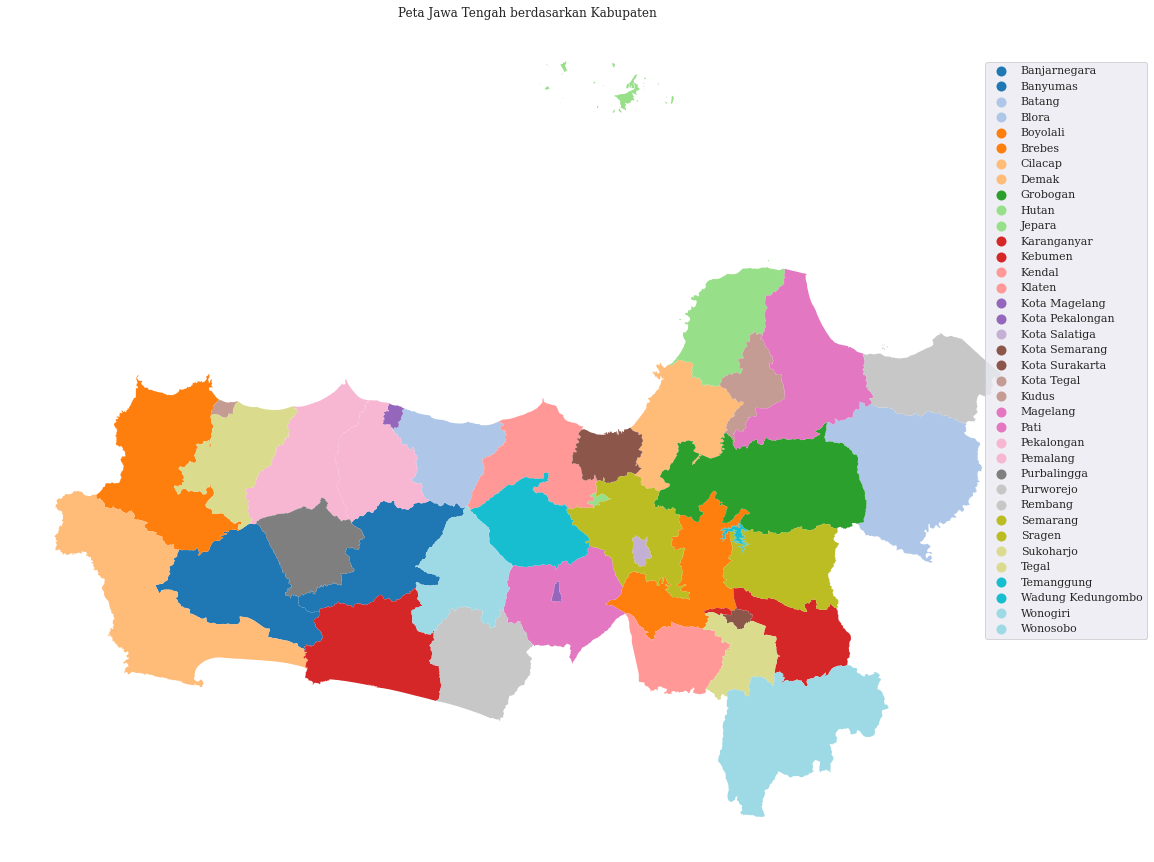

In [ ]:
fig, ax = plt.subplots(figsize=(150, 15))
gdf.plot(column='Kabupaten', cmap = 'tab20', linewidth=0.01, legend=True, legend_kwds={'bbox_to_anchor':(1.10, 0.96)},  ax=ax)
ax.set_title('Peta Jawa Tengah berdasarkan Kabupaten', fontsize=12)
ax.axis("off")
#plt.savefig('myMap.png',dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
kabupaten_to_remove = ['Hutan', 'Wadung Kedungombo']
gdf_filtered = gdf[~gdf['Kabupaten'].isin(kabupaten_to_remove)]

display(gdf_filtered.head())
print(gdf_filtered['Kabupaten'].unique())

,ADM0_EN,date,validOn,PROVINCE,Kabupaten,PRV2,geometry
0,Indonesia,2019-12-20,2020-04-01,Jawa Tengah,Banjarnegara,Jawa_Tengah,"POLYGON ((109.80041 -7.17174, 109.80093 -7.172..."
1,Indonesia,2019-12-20,2020-04-01,Jawa Tengah,Banyumas,Jawa_Tengah,"POLYGON ((109.22521 -7.24726, 109.22526 -7.247..."
2,Indonesia,2019-12-20,2020-04-01,Jawa Tengah,Batang,Jawa_Tengah,"POLYGON ((109.72577 -6.87245, 109.72718 -6.872..."
3,Indonesia,2019-12-20,2020-04-01,Jawa Tengah,Blora,Jawa_Tengah,"POLYGON ((111.2271 -6.84836, 111.2272 -6.84837..."
4,Indonesia,2019-12-20,2020-04-01,Jawa Tengah,Boyolali,Jawa_Tengah,"POLYGON ((110.74606 -7.14104, 110.74616 -7.141..."


['Banjarnegara' 'Banyumas' 'Batang' 'Blora' 'Boyolali' 'Brebes' 'Cilacap'
 'Demak' 'Grobogan' 'Jepara' 'Karanganyar' 'Kebumen' 'Kendal' 'Klaten'
 'Kota Magelang' 'Kota Pekalongan' 'Kota Salatiga' 'Kota Semarang'
 'Kota Surakarta' 'Kota Tegal' 'Kudus' 'Magelang' 'Pati' 'Pekalongan'
 'Pemalang' 'Purbalingga' 'Purworejo' 'Rembang' 'Semarang' 'Sragen'
 'Sukoharjo' 'Tegal' 'Temanggung' 'Wonogiri' 'Wonosobo']


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/GWR/jateng_mmr.csv")
df.head()

,Lokasi,MMR,Jumlah_Dokter,Jumlah_Faskes,Pct_Persalinan_Ditolong_Nakes,Pct_Layanan_Ibu_Nifas
0,Cilacap,41.03,5955,202,100.0,98.9
1,Banyumas,64.18,8855,192,100.1,98.7
2,Purbalingga,66.47,3507,274,99.7,96.9
3,Banjarnegara,95.15,2915,413,99.0,95.1
4,Kebumen,65.77,5086,64,100.0,99.0


In [ ]:
gdf_merged = gdf_filtered.merge(df, left_on='Kabupaten', right_on='Lokasi', how='left')
display(gdf_merged.head())

,ADM0_EN,date,validOn,PROVINCE,Kabupaten,PRV2,geometry,Lokasi,MMR,Jumlah_Dokter,Jumlah_Faskes,Pct_Persalinan_Ditolong_Nakes,Pct_Layanan_Ibu_Nifas
0,Indonesia,2019-12-20,2020-04-01,Jawa Tengah,Banjarnegara,Jawa_Tengah,"POLYGON ((109.80041 -7.17174, 109.80093 -7.172...",Banjarnegara,95.15,2915,413,99.0,95.1
1,Indonesia,2019-12-20,2020-04-01,Jawa Tengah,Banyumas,Jawa_Tengah,"POLYGON ((109.22521 -7.24726, 109.22526 -7.247...",Banyumas,64.18,8855,192,100.1,98.7
2,Indonesia,2019-12-20,2020-04-01,Jawa Tengah,Batang,Jawa_Tengah,"POLYGON ((109.72577 -6.87245, 109.72718 -6.872...",Batang,67.68,2455,230,100.0,99.9
3,Indonesia,2019-12-20,2020-04-01,Jawa Tengah,Blora,Jawa_Tengah,"POLYGON ((111.2271 -6.84836, 111.2272 -6.84837...",Blora,100.05,3129,36,100.0,99.9
4,Indonesia,2019-12-20,2020-04-01,Jawa Tengah,Boyolali,Jawa_Tengah,"POLYGON ((110.74606 -7.14104, 110.74616 -7.141...",Boyolali,114.06,4171,87,99.9,100.6


In [ ]:
# y = gdf_merged['MMR'].values.reshape((-1,1))
# X = gdf_merged[['Jumlah_Dokter', 'Jumlah_Faskes', 'Pct_Persalinan_Ditolong_Nakes', 'Pct_Layanan_Ibu_Nifas']].values
# coords = np.array([(geom.x, geom.y) for geom in gdf_merged.geometry.centroid])

# print(f"Shape of dependent variable (y): {y.shape}")
# print(f"Shape of independent variables (X): {X.shape}")
# print(f"Shape of coordinates (coords): {coords.shape}")

y = gdf_merged['MMR'].values.reshape((-1,1))
X = gdf_merged[['Jumlah_Dokter', 'Jumlah_Faskes', 'Pct_Persalinan_Ditolong_Nakes', 'Pct_Layanan_Ibu_Nifas']].values
coords = np.array([(geom.x, geom.y) for geom in gdf_merged.geometry.centroid])

gdf_utm = gdf_merged.to_crs(epsg=32749)
gdf_utm['rep_point'] = gdf_utm.geometry.representative_point()
u = gdf_utm['rep_point'].x
v = gdf_utm['rep_point'].y
coords = list(zip(u, v))

print(f"Shape of dependent variable (y): {y.shape}")
print(f"Shape of independent variables (X): {X.shape}")
print(f"Shape of coordinates (coords): {np.array(coords).shape}")

print(coords[:5])


Shape of dependent variable (y): (35, 1)
Shape of independent variables (X): (35, 4)
Shape of coordinates (coords): (35, 2)
[(352097.29456553224, 9186644.895574547), (292125.67983961053, 9175587.860621424), (374956.05035850476, 9222532.829780132), (546647.259581629, 9214015.191846617), (467315.9769444221, 9183434.15315637)]


In [ ]:
n = len(coords)

gwr_selector_gaussian = Sel_BW(
    coords,
    y,
    X,
    kernel='gaussian',
    fixed=False

)

gwr_bw_gaussian = gwr_selector_gaussian.search(
    bw_max=n-1,
    bw_min=2
)

print("Optimal adaptive bandwidth global:", gwr_bw_gaussian)

Optimal adaptive bandwidth global: 31.0


In [ ]:
from sklearn.neighbors import NearestNeighbors

# Instantiate NearestNeighbors with the optimal bandwidth (number of neighbors)
nbrs = NearestNeighbors(n_neighbors=int(gwr_bw_gaussian) + 1, algorithm='ball_tree').fit(coords)

# Find the distances to the k-th (gwr_bw_gaussian) nearest neighbor for each point
distances, indices = nbrs.kneighbors(coords)

# The distance to the (gwr_bw_gaussian)-th neighbor is at index gwr_bw_gaussian
# (since indices are 0-based and includes the point itself as the 0-th neighbor)
gdf_merged['Bandwidth Lokal'] = distances[:, int(gwr_bw_gaussian)]

display(gdf_merged[['Kabupaten', 'Bandwidth Lokal']].head())

,Kabupaten,Bandwidth Lokal
0,Banjarnegara,158271.722775
1,Banyumas,216319.538140
2,Batang,147718.032692
3,Blora,256283.782079
4,Boyolali,177424.625298


In [ ]:
gwr_model_gaussian = GWR(coords, y, X, bw=gwr_bw_gaussian, kernel='gaussian', fixed=False)
gwr_results_gaussian = gwr_model_gaussian.fit()
print(gwr_results_gaussian.summary())

Model type                                                         Gaussian
Number of observations:                                                  35
Number of covariates:                                                     5

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                          30496.009
Log-likelihood:                                                    -168.138
AIC:                                                                346.276
AICc:                                                               351.276
BIC:                                                              30389.348
R2:                                                                   0.107
Adj. R2:                                                             -0.013

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [ ]:
# As reference, here is the (average) R2, AIC, and AICc
print('Mean R2 =', gwr_results_gaussian.R2)
print('AIC =', gwr_results_gaussian.aic)
print('AICc =', gwr_results_gaussian.aicc)

Mean R2 = 0.18706142589962194
AIC = 346.7998094678482
AICc = 350.84035919897093


In [ ]:
# Add R2 to GeoDataframe
gdf_merged['gwr_R2'] = gwr_results_gaussian.localR2

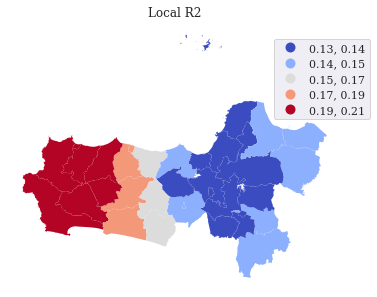

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
gdf_merged.plot(column='gwr_R2', cmap = 'coolwarm', linewidth=0.01, scheme = 'FisherJenks', k=5, legend=True, legend_kwds={'bbox_to_anchor':(1.10, 0.96)},  ax=ax)
ax.set_title('Local R2', fontsize=12)
ax.axis("off")
#plt.savefig('myMap.png',dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# Ambil parameter lokal
params = gwr_results_gaussian.params

# Indeks 0 adalah intercept
gdf_merged['intercept']           = params[:, 0]
gdf_merged['b1_Jumlah_Dokter']    = params[:, 1]
gdf_merged['b2_Faskes']           = params[:, 2]
gdf_merged['b3_Persalinan_Nakes'] = params[:, 3]
gdf_merged['b4_Layanan_Nifas']    = params[:, 4]

# Nilai prediksi lokal
gdf_merged['y_pred_gwr']          = gwr_results_gaussian.predy

display(gdf_merged.head())

,ADM0_EN,date,validOn,PROVINCE,Kabupaten,PRV2,geometry,Lokasi,MMR,Jumlah_Dokter,Jumlah_Faskes,Pct_Persalinan_Ditolong_Nakes,Pct_Layanan_Ibu_Nifas,Bandwidth Lokal,gwr_R2,intercept,b1_Jumlah_Dokter,b2_Faskes,b3_Persalinan_Nakes,b4_Layanan_Nifas,y_pred_gwr
0,Indonesia,2019-12-20,2020-04-01,Jawa Tengah,Banjarnegara,Jawa_Tengah,"POLYGON ((109.80041 -7.17174, 109.80093 -7.172...",Banjarnegara,95.15,2915,413,99.0,95.1,158271.722775,0.185197,700.540377,0.000339,-0.051793,-1.559307,-4.720849,76.813592
1,Indonesia,2019-12-20,2020-04-01,Jawa Tengah,Banyumas,Jawa_Tengah,"POLYGON ((109.22521 -7.24726, 109.22526 -7.247...",Banyumas,64.18,8855,192,100.1,98.7,216319.538140,0.207691,742.796707,0.000398,-0.050466,-2.055834,-4.660250,70.876382
2,Indonesia,2019-12-20,2020-04-01,Jawa Tengah,Batang,Jawa_Tengah,"POLYGON ((109.72577 -6.87245, 109.72718 -6.872...",Batang,67.68,2455,230,100.0,99.9,147718.032692,0.168825,677.569175,0.000341,-0.050660,-1.224556,-4.822620,62.518406
3,Indonesia,2019-12-20,2020-04-01,Jawa Tengah,Blora,Jawa_Tengah,"POLYGON ((111.2271 -6.84836, 111.2272 -6.84837...",Blora,100.05,3129,36,100.0,99.9,256283.782079,0.143365,640.301299,0.000309,-0.053644,-0.843117,-4.819791,73.528016
4,Indonesia,2019-12-20,2020-04-01,Jawa Tengah,Boyolali,Jawa_Tengah,"POLYGON ((110.74606 -7.14104, 110.74616 -7.141...",Boyolali,114.06,4171,87,99.9,100.6,177424.625298,0.133883,607.813268,0.000239,-0.055022,-0.525668,-4.801920,68.434762


In [ ]:
# Filter t-values: standard alpha = 0.05
gwr_filtered_t = gwr_results_gaussian.filter_tvals(alpha = 0.05)
pd.DataFrame(gwr_filtered_t)

,0,1,2,3,4
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Filter t-values: corrected alpha due to multiple testing
gwr_filtered_tc = gwr_results_gaussian.filter_tvals()
pd.DataFrame(gwr_filtered_tc)

,0,1,2,3,4
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0


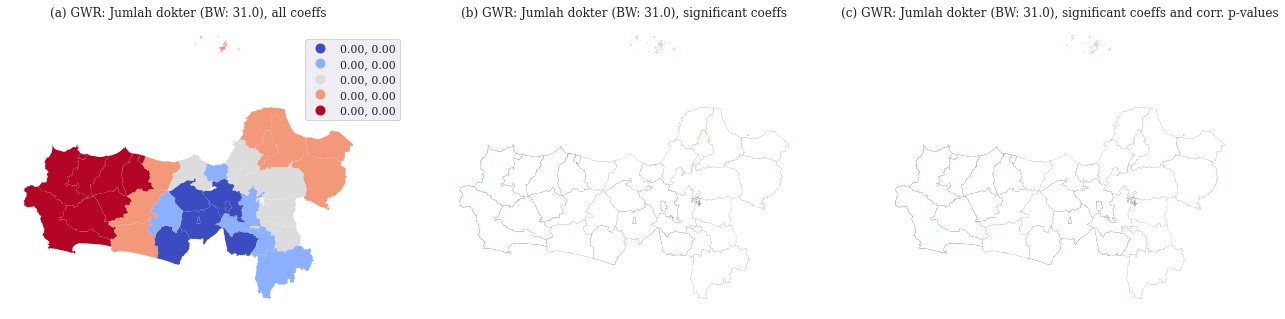

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,6))

gdf_merged.plot(column='b1_Jumlah_Dokter', cmap = 'coolwarm', linewidth=0.01, scheme = 'FisherJenks', k=5, legend=True, legend_kwds={'bbox_to_anchor':(1.10, 0.96)},  ax=axes[0])

gdf_merged.plot(column='b1_Jumlah_Dokter', cmap = 'coolwarm', linewidth=0.05, scheme = 'FisherJenks', k=5, legend=False, legend_kwds={'bbox_to_anchor':(1.10, 0.96)},  ax=axes[1])
gdf_merged[gwr_filtered_t[:,1] == 0].plot(color='white', linewidth=0.05, edgecolor='black', ax=axes[1])


gdf_merged.plot(column='b1_Jumlah_Dokter', cmap = 'coolwarm', linewidth=0.05, scheme = 'FisherJenks', k=5, legend=False, legend_kwds={'bbox_to_anchor':(1.10, 0.96)},  ax=axes[2])
gdf_merged[gwr_filtered_tc[:,1] == 0].plot(color='white', linewidth=0.05, edgecolor='black', ax=axes[2])

plt.tight_layout()

axes[0].axis("off")
axes[1].axis("off")
axes[2].axis("off")

axes[0].set_title('(a) GWR: Jumlah dokter (BW: ' + str(gwr_bw_gaussian) +'), all coeffs', fontsize=12)
axes[1].set_title('(b) GWR: Jumlah dokter (BW: ' + str(gwr_bw_gaussian) +'), significant coeffs',     fontsize=12)
axes[2].set_title('(c) GWR: Jumlah dokter (BW: ' + str(gwr_bw_gaussian) +'), significant coeffs and corr. p-values',     fontsize=12)
plt.show()

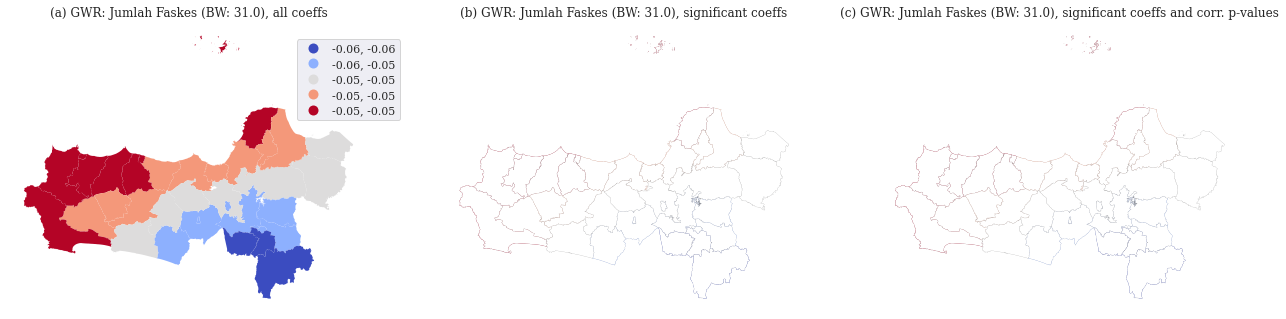

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,6))

gdf_merged.plot(column='b2_Faskes', cmap = 'coolwarm', linewidth=0.01, scheme = 'FisherJenks', k=5, legend=True, legend_kwds={'bbox_to_anchor':(1.10, 0.96)},  ax=axes[0])

gdf_merged.plot(column='b2_Faskes', cmap = 'coolwarm', linewidth=0.05, scheme = 'FisherJenks', k=5, legend=False, legend_kwds={'bbox_to_anchor':(1.10, 0.96)},  ax=axes[1])
gdf_merged[gwr_filtered_t[:,2] == 0].plot(color='white', linewidth=0.05, edgecolor='black', ax=axes[1])


gdf_merged.plot(column='b2_Faskes', cmap = 'coolwarm', linewidth=0.05, scheme = 'FisherJenks', k=5, legend=False, legend_kwds={'bbox_to_anchor':(1.10, 0.96)},  ax=axes[2])
gdf_merged[gwr_filtered_tc[:,2] == 0].plot(color='white', linewidth=0.05, edgecolor='black', ax=axes[2])

plt.tight_layout()

axes[0].axis("off")
axes[1].axis("off")
axes[2].axis("off")

axes[0].set_title('(a) GWR: Jumlah Faskes (BW: ' + str(gwr_bw_gaussian) +'), all coeffs', fontsize=12)
axes[1].set_title('(b) GWR: Jumlah Faskes (BW: ' + str(gwr_bw_gaussian) +'), significant coeffs',     fontsize=12)
axes[2].set_title('(c) GWR: Jumlah Faskes (BW: ' + str(gwr_bw_gaussian) +'), significant coeffs and corr. p-values',     fontsize=12)
plt.show()

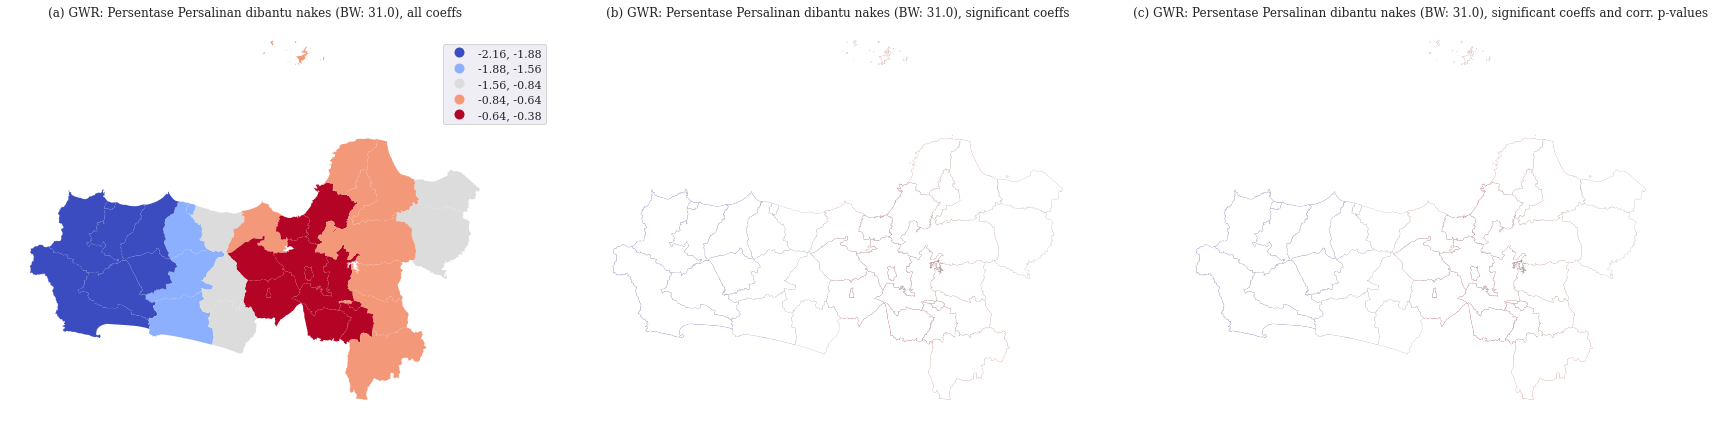

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24,6))

gdf_merged.plot(column='b3_Persalinan_Nakes', cmap = 'coolwarm', linewidth=0.01, scheme = 'FisherJenks', k=5, legend=True, legend_kwds={'bbox_to_anchor':(1.10, 0.96)},  ax=axes[0])

gdf_merged.plot(column='b3_Persalinan_Nakes', cmap = 'coolwarm', linewidth=0.05, scheme = 'FisherJenks', k=5, legend=False, legend_kwds={'bbox_to_anchor':(1.10, 0.96)},  ax=axes[1])
gdf_merged[gwr_filtered_t[:,3] == 0].plot(color='white', linewidth=0.05, edgecolor='black', ax=axes[1])


gdf_merged.plot(column='b3_Persalinan_Nakes', cmap = 'coolwarm', linewidth=0.05, scheme = 'FisherJenks', k=5, legend=False, legend_kwds={'bbox_to_anchor':(1.10, 0.96)},  ax=axes[2])
gdf_merged[gwr_filtered_tc[:,3] == 0].plot(color='white', linewidth=0.05, edgecolor='black', ax=axes[2])

plt.tight_layout()

axes[0].axis("off")
axes[1].axis("off")
axes[2].axis("off")

axes[0].set_title('(a) GWR: Persentase Persalinan dibantu nakes (BW: ' + str(gwr_bw_gaussian) +'), all coeffs', fontsize=12)
axes[1].set_title('(b) GWR: Persentase Persalinan dibantu nakes (BW: ' + str(gwr_bw_gaussian) +'), significant coeffs',     fontsize=12)
axes[2].set_title('(c) GWR: Persentase Persalinan dibantu nakes (BW: ' + str(gwr_bw_gaussian) +'), significant coeffs and corr. p-values',     fontsize=12)
plt.show()

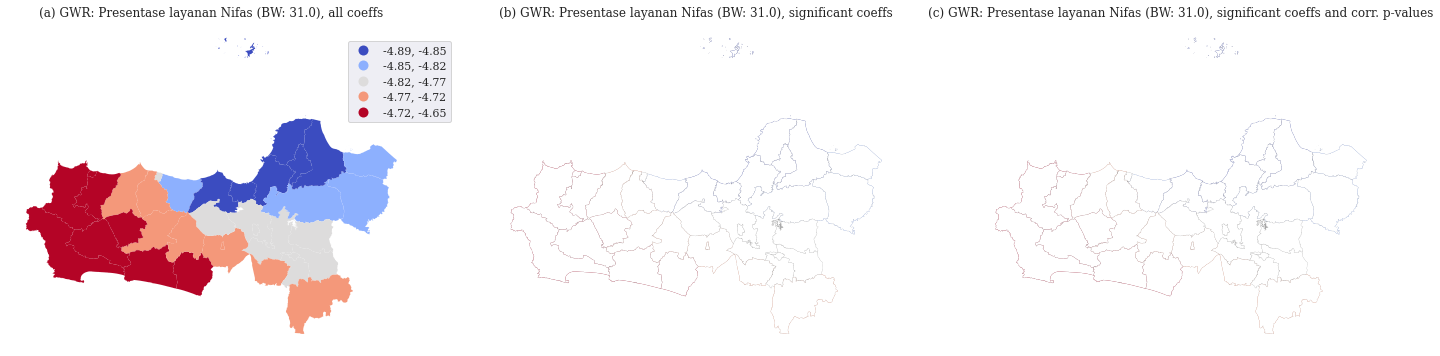

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,6))

gdf_merged.plot(column='b4_Layanan_Nifas', cmap = 'coolwarm', linewidth=0.01, scheme = 'FisherJenks', k=5, legend=True, legend_kwds={'bbox_to_anchor':(1.10, 0.96)},  ax=axes[0])

gdf_merged.plot(column='b4_Layanan_Nifas', cmap = 'coolwarm', linewidth=0.05, scheme = 'FisherJenks', k=5, legend=False, legend_kwds={'bbox_to_anchor':(1.10, 0.96)},  ax=axes[1])
gdf_merged[gwr_filtered_t[:,4] == 0].plot(color='white', linewidth=0.05, edgecolor='black', ax=axes[1])


gdf_merged.plot(column='b4_Layanan_Nifas', cmap = 'coolwarm', linewidth=0.05, scheme = 'FisherJenks', k=5, legend=False, legend_kwds={'bbox_to_anchor':(1.10, 0.96)},  ax=axes[2])
gdf_merged[gwr_filtered_tc[:,4] == 0].plot(color='white', linewidth=0.05, edgecolor='black', ax=axes[2])

plt.tight_layout()

axes[0].axis("off")
axes[1].axis("off")
axes[2].axis("off")

axes[0].set_title('(a) GWR: Presentase layanan Nifas (BW: ' + str(gwr_bw_gaussian) +'), all coeffs', fontsize=12)
axes[1].set_title('(b) GWR: Presentase layanan Nifas (BW: ' + str(gwr_bw_gaussian) +'), significant coeffs',     fontsize=12)
axes[2].set_title('(c) GWR: Presentase layanan Nifas (BW: ' + str(gwr_bw_gaussian) +'), significant coeffs and corr. p-values',     fontsize=12)
plt.show()